In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import glob
import seaborn as sns
import pandas as pd
import cv2
import os
from keras.applications.densenet import DenseNet169
from keras.applications.mobilenet import MobileNet
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectKBest, chi2
import lightgbm as lgb
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
! pip install kaggle


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
! unzip /content/gdrive/MyDrive/Colab\ Notebooks/brain.zip

Mounted at /content/gdrive
Archive:  /content/gdrive/MyDrive/Colab Notebooks/brain.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
 

## loading the dataset

In [ ]:
SIZE = 224
images = []
images_labels = []

### importing each image and set the current directory name as its label

In [ ]:
ext = ['png', 'jpg', 'jpeg'] #extensões de arquivo de imagem que o código irá considerar: 'png', 'jpg' e 'jpeg'.

for directory_path in glob.glob("/content/brain_tumor_dataset/no"): #navegando pelo path do DataSet, pasta "No"
    splited = directory_path.split("/")
    label = splited[-1]
    print(label)
    for e in ext:
        for img_path in glob.glob(os.path.join(directory_path, "*." + e)):  #itera sobre as extensões de arquivo ('png', 'jpg', 'jpeg')
           #print(img_path)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR) #Lê a imagem usando a biblioteca OpenCV, "cv2.imread" é usado para ler uma imagem de um arquivo. "cv2.IMREAD_COLOR" indica que a imagem deve ser lida em cores
            img = cv2.resize(img, (SIZE, SIZE)) #Redimensiona a imagem para um tamanho específico (SIZE, SIZE). O valor de SIZE definido anteriormente (224)
            images.append(img) #Adiciona a imagem redimensionada à lista images.
            images_labels.append(label) #Adiciona o rótulo (label) associado a esta imagem à lista images_labels.

for directory_path in glob.glob("/content/brain_tumor_dataset/yes"): #navegando pelo path do DataSet, pasta "Yes"
    splited = directory_path.split("/")
    label = splited[-1]
    print(label)
    for e in ext:
        for img_path in glob.glob(os.path.join(directory_path, "*." + e)): #itera sobre as extensões de arquivo ('png', 'jpg', 'jpeg')
           #print(img_path)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR) #Lê a imagem usando a biblioteca OpenCV, "cv2.imread" é usado para ler uma imagem de um arquivo. "cv2.IMREAD_COLOR" indica que a imagem deve ser lida em cores
            img = cv2.resize(img, (SIZE, SIZE)) #Redimensiona a imagem para um tamanho específico (SIZE, SIZE). O valor de SIZE definido anteriormente (224)
            images.append(img) #Adiciona a imagem redimensionada à lista images.
            images_labels.append(label) #Adiciona o rótulo (label) associado a esta imagem à lista images_labels.

no
yes


In [ ]:
images = np.array(images) #aqui, a lista images está sendo convertida em um array NumPy usando a função np.array(), significa que agora images é uma matriz NumPy que contém as imagens.
images_labels = np.array(images_labels)
images.shape

(179, 224, 224, 3)

In [ ]:
np.unique(images_labels) #rótulos originais dos dados (por exemplo, "no" e "yes" para o caso de detecção de tumores cerebrais) ou os rótulos transformados (se você usou o LabelEncoder para convertê-los em valores numéricos).

array(['no', 'yes'], dtype='<U3')

## Pre-processing

### label encoding

In [ ]:
le = preprocessing.LabelEncoder() #cria uma instância do LabelEncoder chamada "le", classe do scikit-learn usada para transformar rótulos de texto em números.
le.fit(images_labels) #aprender os mapeamentos entre rótulos de texto e números. Neste caso, ele está sendo ajustado aos rótulos contidos na lista images_labels.
labels_encoded = le.transform(images_labels) #converter os rótulos de texto em números usando o mapeamento aprendido com o fit. Os rótulos transformados são armazenados na variável labels_encoded.

## Feature Extraction

### DenseNet169

In [ ]:
dense_model = DenseNet169(
    include_top=False, input_shape=(SIZE, SIZE, 3), pooling='avg') # criando uma instância de um modelo de rede neural convolucional chamado DenseNet169
#"include_top=false" significa que a camada superior(top layer) do modelo não será incluída. A camada superior normalmente é uma camada fully connected que é responsável pela classificação final.
#Pooling "avg" Calcula a média dos valores em cada região, o que ajuda a reduzir o tamanho da representação e a manter informações relevantes.

51877672/51877672 [==============================] - 0s 0us/step


In [ ]:
dense_features = dense_model.predict(images)
#é um método que faz previsões com base nas imagens fornecidas. (.predict)
#isso significa passar as imagens pelo modelo e obter as saídas previstas
#os recursos (features) extraídos pela rede neural, que serão usados para treinar um classificador ou para outra tarefa de aprendizado de máquina.

6/6 [==============================] - 61s 8s/step


In [ ]:
features = dense_features.reshape(dense_features.shape[0], -1)
#extrai o número de features no conjunto de dados, "dense_features.shape" retorna a forma do array
#"reshape" é usada para remodelar o array "dense_features" com as novas dimensões especificadas, o número de linhas é mantido como o número de exemplos,
#enquanto o número de colunas é calculado automaticamente para garantir que o número total de elementos seja o mesmo.

In [ ]:
features.shape
#retorna um array com 179 amostras e cada amostra tem 1664 características.
#Se você executar features.shape, ele retornará o formato específico do array features:

(179, 1664)

### Mobilenet

In [ ]:
model_mobile = MobileNet(weights='imagenet', include_top=False,
                         input_shape=(SIZE, SIZE, 3), pooling='avg')
#modelo que está sendo instanciado. MobileNet é uma arquitetura de rede neural convolucional otimizada para aplicações com recursos computacionais limitados.
#Indica que os pesos pré-treinados do modelo na base de dados ImageNet serão usados. Os pesos pré-treinados são úteis para iniciar o treinamento com uma inicialização que já tenha aprendido muitos padrões úteis.

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
mobile_features = model_mobile.predict(images)
#model_mobile é uma rede neural convolucional baseada na arquitetura MobileNet.
#.predict(images) é um método que faz previsões com base nas imagens fornecidas.

6/6 [==============================] - 10s 2s/step


In [ ]:
features_2 = mobile_features.reshape(mobile_features.shape[0], -1)
#extrai o número de features no conjunto de dados, "dense_features.shape" retorna a forma do array
#"reshape" é usada para remodelar o array "dense_features" com as novas dimensões especificadas, o número de linhas é mantido como o número de exemplos,
#enquanto o número de colunas é calculado automaticamente para garantir que o número total de elementos seja o mesmo.

In [ ]:
features_2.shape
#retorna um array com 179 amostras e cada amostra tem 1024 características.
#Se você executar features.shape, ele retornará o formato específico do array features:

(179, 1024)

## Feature Combination

In [ ]:
combined_features = np.hstack((dense_features, mobile_features))
#combinando as features obtidos a partir dos modelos DenseNet169 e MobileNet em uma única matriz usando a função "np.hstack"
#"np.hstack" usada para empilhar os arrays, neste caso, está sendo usada para combinar as features horizontalmente.
#"dense_features" array que contém os recursos extraídos do modelo DenseNet169.
#"mobile_features" array que contém os recursos extraídos do modelo MobileNet.

In [ ]:
combined_features.shape
#retorna a forma do array combined_features
#A forma de combined_features dependerá do número de amostras e do número total de features após a combinação dos recursos dos modelos DenseNet169 e MobileNet.
#As mesmas 179, com o somatório de 2688 das features.

(179, 2688)

## lightgbm classifier

In [ ]:
params = {'learning_rate': 0.2, 'n_iterations': 500, 'max_depth': 7, #learning_rate: A taxa de aprendizado controla a magnitude das atualizações de peso durante o treinamento.
          'num_leaves': 105, 'n_estimators': 300, 'min_child_samples': 40} #min_child_samples: O número mínimo de amostras necessárias para considerar uma folha em uma árvore.
#lightgbm é um algoritmo de boosting: é um conjunto de técnicas de aprendizado de máquina que visa melhorar o desempenho de modelos preditivos
#ao combinar a previsão de vários modelos mais fracos para criar um modelo mais forte e preciso.  (treina como árvores de decisão rasas ou regressores lineares simples)

#

In [ ]:
lgb_classifier = lgb.LGBMClassifier(**params)
#lgb_classifier será uma instância do classificador do LightGBM, configurada com os parâmetros especificados em params.
#Isso significa que você pode usar lgb_classifier para treinar e fazer previsões dos seus dados.

## Feature Selection

In [ ]:
selected_features = SelectKBest(chi2, k=2000).fit_transform(
    combined_features, labels_encoded)
#seleção de características para escolher as 2000 características mais relevantes do conjunto de dados.

In [ ]:
selected_features.shape
#retorna a forma do array selected_features
##As mesmas 179, com o somatório de 2000 das features.

(179, 2000)

## KFold cross validation

In [ ]:
#validação cruzada usando o classificador LightGBM para avaliar o desempenho do modelo em diferentes conjuntos de treinamento e teste.

accuracy_per_fold = {} #dicionário onde vamos armazenar as métricas de precisão para cada fold

for i in range(0, 10):
    kf = KFold(n_splits=5, random_state=i, shuffle=True) #KFold para realizar a validação cruzada com 5 folds.
                                    #random_state=i garante que a divisão dos dados seja a mesma para cada iteração, mas com diferentes sementes de aleatoriedade devido ao loop
    accuracy = cross_val_score(
        lgb_classifier, selected_features, labels_encoded, cv=kf, scoring='accuracy') #"cross_val_score", função do scikit-learn é usada para executar a validação cruzada.
    accuracy_per_fold[i] = np.mean(accuracy)
    #"np.mean(accuracy)" calcula a média das métricas de precisão para todos os folds. Isso fornece uma estimativa do desempenho geral do modelo.


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
for key, value in accuracy_per_fold.items():
    if value == max(accuracy_per_fold.values()):
        print(key)
#percorrendo os itens do dicionário "accuracy_per_fold" e identificando a chave (que corresponde à iteração) que possui o valor máximo de precisão.

3


## Confusion matrix

In [ ]:
#visão detalhada do desempenho do modelo ao classificar os dados em diferentes classes.
#Cada célula da matriz vai representa o número de instâncias que foram classificadas de uma determinada maneira.
kf = KFold(n_splits=5, random_state=1, shuffle=True)
cm = {}
key = 1
accuracy = {}

for train, test in kf.split(selected_features):
    x_train, x_test = selected_features[train], selected_features[test]
    y_train, y_test = labels_encoded[train], labels_encoded[test]

    lgb_classifier.fit(x_train, y_train)
    cm[key] = confusion_matrix(y_test, lgb_classifier.predict(x_test))
    accuracy[key] = accuracy_score(y_test, lgb_classifier.predict(x_test))
    key += 1

#Ao final desse loop, "cm" conterá as matrizes de confusão para cada fold, e accuracy conterá as precisões para cada fold.
#Essas métricas podem ser úteis para avaliar o desempenho do modelo em cada divisão da validação cruzada.

[LightGBM] [Warning] Unknown parameter: n_iterations
[LightGBM] [Warning] Unknown parameter: n_iterations
[LightGBM] [Info] Number of positive: 72, number of negative: 71
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76861
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 1862
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503497 -> initscore=0.013986
[LightGBM] [Info] Start training from score 0.013986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [ ]:
accuracy
#retorna um dicionário chamado "accuracy" com a precisão para cada fold.

{1: 0.8333333333333334,
 2: 0.9166666666666666,
 3: 0.9166666666666666,
 4: 0.8055555555555556,
 5: 0.8}

## Confusion matrix HeatMap

<Figure size 3000x2000 with 0 Axes>

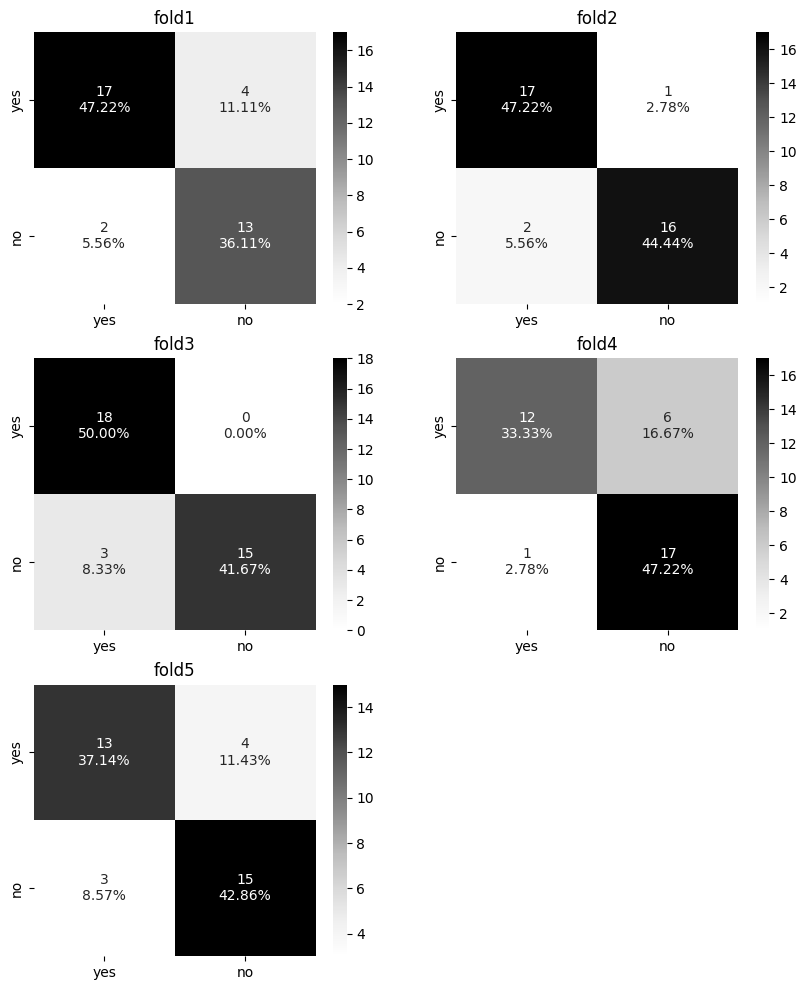

In [ ]:
#Plot da matriz de confusão: HeatMap
key = 1
plt.figure(figsize=(30, 20))
fig, axs = plt.subplots(3, 2, figsize=(10, 12))
fig.delaxes(axs[2, 1])
categories = ['yes', 'no']

for i in range(3):
    for j in range(2):
        if key in range(1, 6):
            counts = ['{0:0.0f}'.format(value) for value in
                      cm[key].flatten()]
            group_percentages = ['{0:.2%}'.format(value) for value in
                                 cm[key].flatten()/np.sum(cm[key])]
            labels = [f'{v1}\n{v2}' for v1, v2 in
                      zip(counts, group_percentages)]
            labels = np.asarray(labels).reshape(2, 2)

            sns.heatmap(cm[key], ax=axs[i, j], annot=labels, fmt='',
                        xticklabels=categories, yticklabels=categories, cmap='Greys')
            axs[i, j].set_title(f'fold{key}')
            key += 1

In [ ]:
pp = PdfPages("heatmap.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()

## Performance checking

In [ ]:
def confusion_metrics(cm):
    TP = cm[1][1] #verdadeiro positivo
    TN = cm[0][0] #verdadeiro negativo
    FP = cm[0][1] #falso positivo
    FN = cm[1][0] #falso negativo
    sensitivity = TP / (FN + TP) #proporção de verdadeiros positivos (casos positivos corretamente identificados) em relação a todos os casos positivos reais.
    specificity = TN / (TN + FP) #verdadeiros negativos (casos negativos corretamente identificados) em relação a todos os casos negativos reais.
    precision = TP / (TP + FP) # verdadeiros positivos em relação a todos os casos classificados como positivos pelo modelo.
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) #média harmônica da sensibilidade e da precisão

    result = {'Sensitivity': sensitivity*100, 'Specificity': specificity *
              100, 'Precision': precision*100, 'F1-Score': f1_score*100} #todos multiplicados por 100 para expressar relações em percentuais.
    return result

In [ ]:
performance = pd.DataFrame(
    columns=['Folds', 'Sensitivity', 'Specificity', 'Precision', 'F1-Score', 'Accuracy'])
performance

,Folds,Sensitivity,Specificity,Precision,F1-Score,Accuracy


In [ ]:
for index in range(1, 6):
    cf = cm[index]
    metrics = confusion_metrics(cf)
    all_in_one = {**{'Folds': f'fold {index}'}, **
                  metrics, **{'Accuracy': accuracy[index]*100}}
    performance = performance.append(all_in_one, ignore_index=True)
    #"performance" conterá informações de desempenho para cada fold, incluindo as métricas de desempenho e a acurácia.
    #Cada linha no dataframe corresponderá a um fold específico.

<ipython-input-31-abc38a4ee79e>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(all_in_one, ignore_index=True)
<ipython-input-31-abc38a4ee79e>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(all_in_one, ignore_index=True)
<ipython-input-31-abc38a4ee79e>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(all_in_one, ignore_index=True)
<ipython-input-31-abc38a4ee79e>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(all_in_one, ignore_index=True)
<ipython-input-31-abc38a4ee79e>:6: FutureWarning: The frame.appe

In [ ]:
performance

,Folds,Sensitivity,Specificity,Precision,F1-Score,Accuracy
0,fold 1,86.666667,80.952381,76.470588,81.250000,83.333333
1,fold 2,88.888889,94.444444,94.117647,91.428571,91.666667
2,fold 3,83.333333,100.000000,100.000000,90.909091,91.666667
3,fold 4,94.444444,66.666667,73.913043,82.926829,80.555556
4,fold 5,83.333333,76.470588,78.947368,81.081081,80.000000


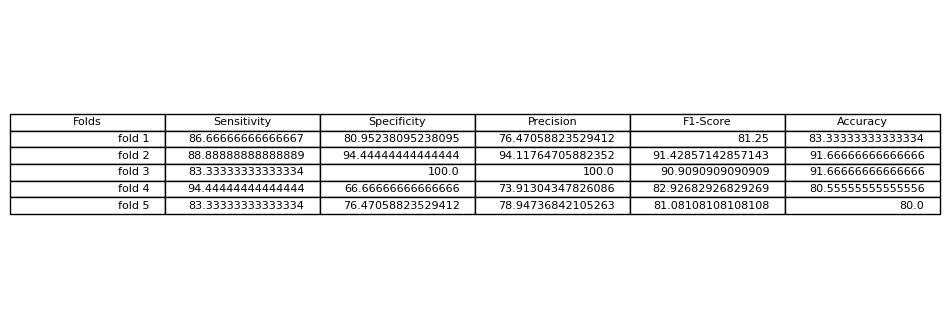

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=performance.values,
                     colLabels=performance.columns, loc='center')

pp = PdfPages("confusion_metrics.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()
#visualização das métricas em PDF, facilitando o entendimento e simplificando os números

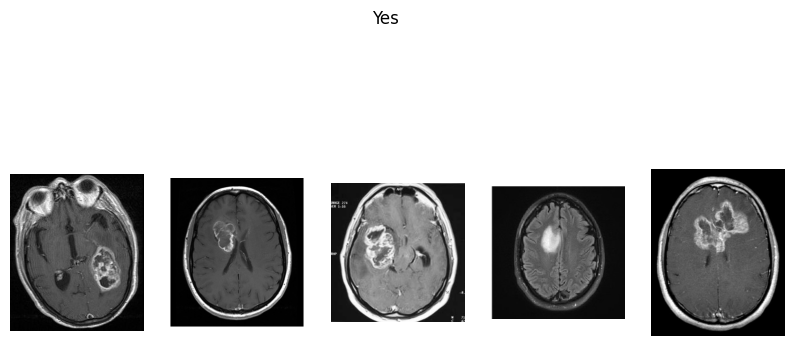

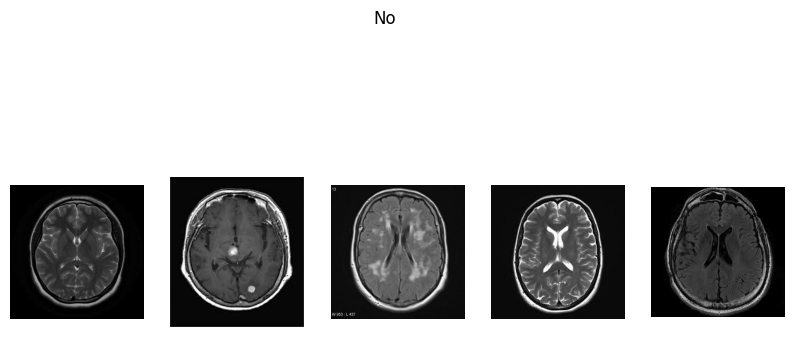

In [ ]:
def display_sample_images(path, title):
    images = [cv2.imread(file) for file in glob.glob(path)[:5]]
    plt.figure(figsize=(10,5))
    for idx, img in enumerate(images):
        plt.subplot(1, 5, idx+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

display_sample_images("/content/yes/*", "Yes")
display_sample_images("/content/no/*", "No")

#chamando a função "display_sample_images" duas vezes, uma vez com o caminho para as imagens "yes" e outra vez com o caminho para as imagens "no".
#isso irá exibir uma amostra de imagens para cada categoria.


[LightGBM] [Warning] Unknown parameter: n_iterations


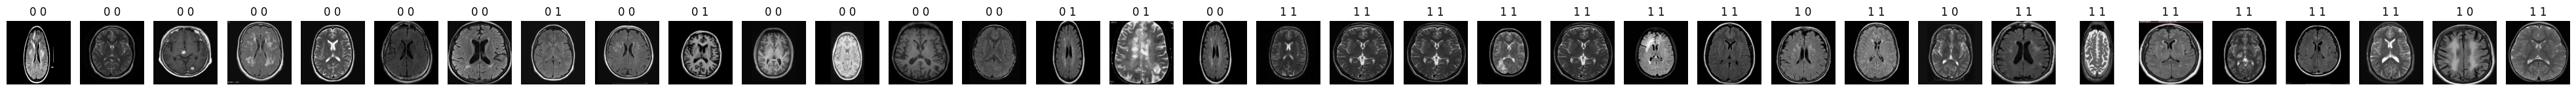

In [ ]:
#teste prático do modelo:

def display_images_with_labels_and_predictions(images, true_labels, predictions):
    plt.figure(figsize=(100,100))
    for idx, (img, true, pred) in enumerate(zip(images, true_labels, predictions)):
        plt.subplot(2, len(images)//2, idx+1)  # Adjust the layout as needed
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"{true} {pred}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

pred = lgb_classifier.predict(x_test)

display_images_with_labels_and_predictions(images, y_test, pred)

#"display_images_with_labels_and_predictions" que aceita três argumentos:
#images (as imagens a serem exibidas), true_labels (as etiquetas verdadeiras) e predictions (as previsões feitas pelo modelo).


